In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 200, canonicalize_fmap=None
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 200, canonicalize_fmap=None
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.38it/s]


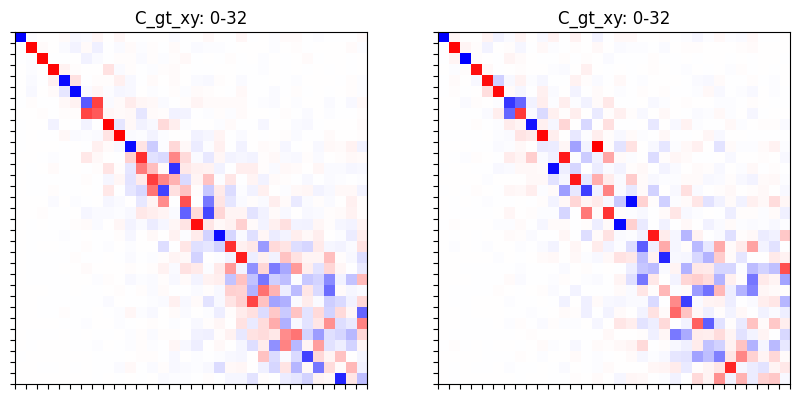

In [3]:
import my_code.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], test_dataset[1]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [4]:
def predict_support_vector(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip
    
    return product_with_support, support_vector_norm
    
    # product_with_support = support_vector_flip.transpose(1, 2) @ evecs_flip
    
    # return product_with_support, None

In [48]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0
feature_dim = 6

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim + condition_dim,
    out_channels=feature_dim,
    # hidden_channels=feature_dim // 2,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


loss=0.1203:  10%|███████▍                                                                   | 3000/30001 [03:30<31:27, 14.31it/s]

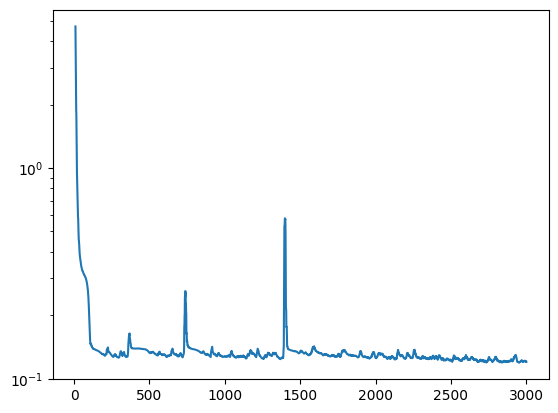

loss=0.1197:  20%|██████████████▉                                                            | 6000/30001 [07:01<28:09, 14.20it/s]

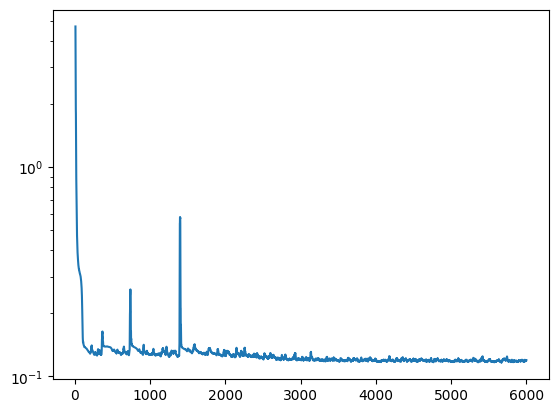

loss=0.1163:  30%|██████████████████████▍                                                    | 9000/30001 [10:32<24:37, 14.22it/s]

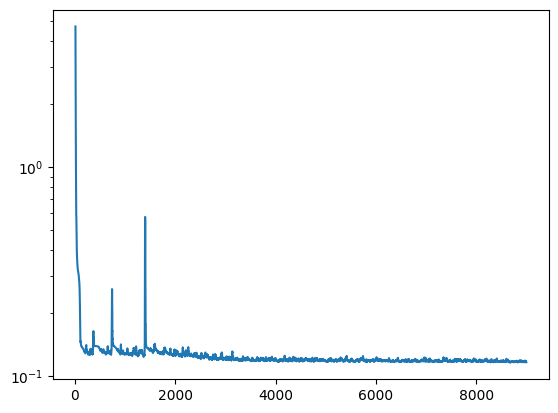

loss=0.1018:  40%|█████████████████████████████▌                                            | 12000/30001 [14:03<21:07, 14.20it/s]

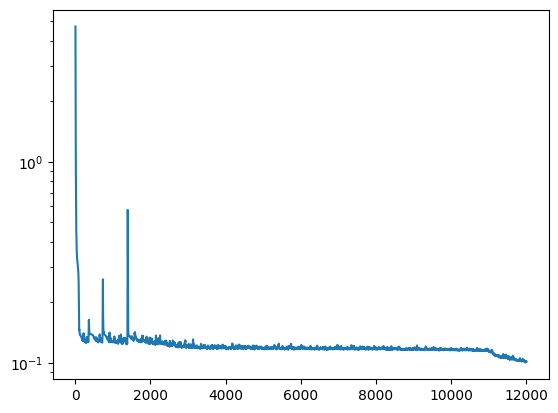

loss=0.0881:  50%|████████████████████████████████████▉                                     | 15000/30001 [17:35<17:41, 14.13it/s]

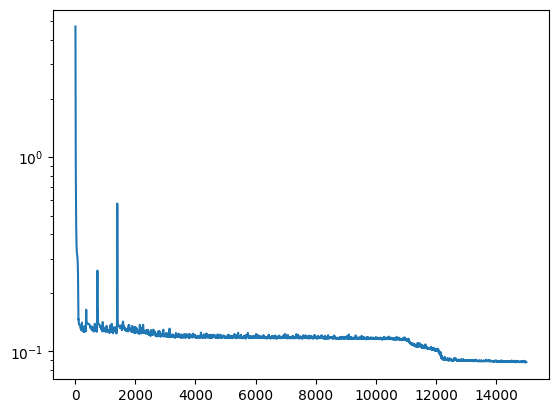

loss=0.0873:  60%|████████████████████████████████████████████▍                             | 18000/30001 [21:07<14:06, 14.18it/s]

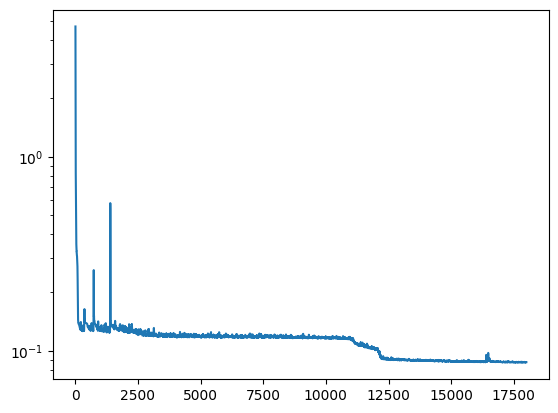

loss=0.0860:  70%|███████████████████████████████████████████████████▊                      | 21000/30001 [24:38<10:33, 14.22it/s]

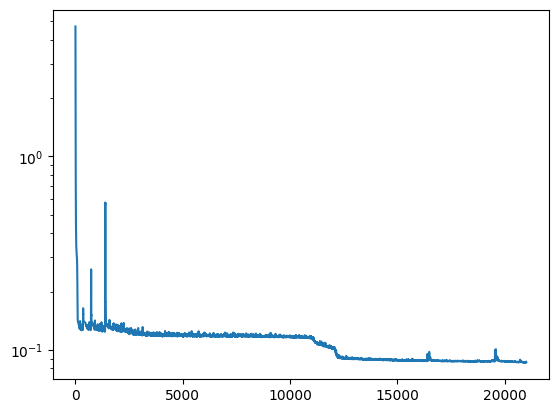

loss=0.0840:  80%|███████████████████████████████████████████████████████████▏              | 24000/30001 [28:07<06:45, 14.79it/s]

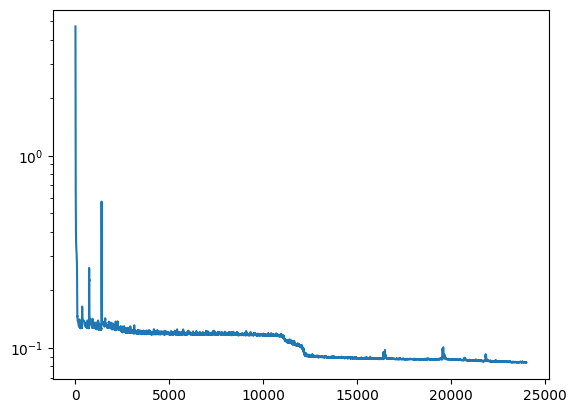

loss=0.0843:  81%|████████████████████████████████████████████████████████████              | 24345/30001 [28:31<06:37, 14.23it/s]


KeyboardInterrupt: 

In [49]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import my_code.permutation_utils as permutation_utils


loss_fn = torch.nn.MSELoss(reduction='mean')
losses = torch.tensor([])
iterator = tqdm(range(30001))

# possible_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
possible_shapes = [train_dataset[i]['second'] for i in range(1)]
                   
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    
    # take the absolute value
    evecs_orig = evecs_orig.abs()
    
    ##############################################
    # Permutation 1
    ##############################################

    # create a random permutation matrix
    perm_gt_1 = torch.eye(feature_dim).to(device)
    perm_gt_1 = perm_gt_1[torch.randperm(perm_gt_1.shape[0])]  
    
    # permute the evecs
    evecs_perm_1 = evecs_orig @ perm_gt_1
    
    # predict the permutation
    product_with_support_1, _ = predict_support_vector(
        net, verts, faces, evecs_perm_1, evecs_cond=None)
    
    # take the absolute value
    perm_pred_1 = product_with_support_1.squeeze(0).abs()
     
     
    ##############################################
    # Permutation 2
    ##############################################

    # create a random permutation matrix
    perm_gt_2 = torch.eye(feature_dim).to(device)
    perm_gt_2 = perm_gt_2[torch.randperm(perm_gt_2.shape[0])]  
    
    # permute the evecs
    evecs_perm_2 = evecs_orig @ perm_gt_2
    
    # predict the permutation
    product_with_support_2, _ = predict_support_vector(
        net, verts, faces, evecs_perm_2, evecs_cond=None)
    
    # take the absolute value
    perm_pred_2 = product_with_support_2.squeeze(0).abs()
     
     
    ##############################################
    # Calculate the loss
    ##############################################
    
    lhs = perm_gt_2.T @ perm_gt_1
    # rhs = perm_pred_2 @ perm_pred_1.T
    rhs = perm_pred_2.T @ perm_pred_1
    
    # rhs = perm_pred_2 @ torch.inverse(perm_pred_1)
    
    # calculate the loss
    loss = loss_fn(
        lhs,
        rhs
        )


    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.4f}')
    
    # plot the losses every 1000 iterations
    if i > 0 and i % (len(iterator) // 10) == 0:
        pd.Series(losses.numpy()).rolling(10).mean().plot()
        plt.yscale('log')
        plt.show()


In [25]:
perm_pred_1, perm_pred_2

(tensor([[0.5436, 0.6673, 0.0025, 0.0090, 0.2831, 0.0118],
         [0.0043, 0.0330, 0.0106, 0.4416, 0.1903, 0.0056],
         [0.0032, 0.3772, 0.6061, 0.0418, 0.0027, 0.0890],
         [0.1260, 0.0027, 0.3452, 0.5981, 0.2966, 0.0053],
         [0.0014, 0.0025, 0.0119, 0.3393, 0.0018, 0.3862],
         [0.0073, 0.0019, 0.0012, 0.0016, 0.2409, 0.8330]], device='cuda:0',
        grad_fn=<AbsBackward0>),
 tensor([[8.2038e-03, 2.8313e-01, 3.4735e-03, 5.4257e-01, 6.6671e-01, 1.0337e-02],
         [4.4248e-01, 1.9136e-01, 1.2086e-02, 5.4313e-03, 3.3562e-02, 6.7768e-03],
         [4.2338e-02, 3.6168e-03, 6.0626e-01, 3.2648e-03, 3.7758e-01, 8.7338e-02],
         [5.9883e-01, 2.9727e-01, 3.4623e-01, 1.2722e-01, 2.0123e-03, 6.5882e-03],
         [3.4214e-01, 4.4314e-03, 1.4814e-02, 3.5397e-03, 2.9529e-03, 3.8171e-01],
         [9.0580e-05, 2.4011e-01, 4.4540e-03, 9.0340e-03, 2.0016e-03, 8.3259e-01]],
        device='cuda:0', grad_fn=<AbsBackward0>))

In [18]:
evecs_orig_norm = torch.nn.functional.normalize(evecs_orig, p=2, dim=1)
evecs_orig_norm @ evecs_orig_norm.transpose(1, 2), evecs_orig_norm[:, 0]


(tensor([[[0.0009, 0.0009, 0.0009,  ..., 0.0008, 0.0008, 0.0008],
          [0.0009, 0.0009, 0.0009,  ..., 0.0008, 0.0008, 0.0008],
          [0.0009, 0.0009, 0.0009,  ..., 0.0008, 0.0008, 0.0008],
          ...,
          [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
          [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
          [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008]]],
        device='cuda:0'),
 tensor([[-1.2047e-02, -1.0144e-02, -1.2877e-04, -2.0260e-05,  1.0694e-02,
           2.2974e-02]], device='cuda:0'))

In [50]:
# test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]
test_shapes_list = [train_dataset[i]['second'] for i in range(1)]
                   
iterator = tqdm(range(1001))

incorrect_pred_list = torch.tensor([])
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    # test_shape = test_shapes_list[i]
    
    curr_idx = np.random.randint(0, len(test_shapes_list))   
    test_shape = test_shapes_list[curr_idx]    

    verts = test_shape['verts'].unsqueeze(0).to(device)
    faces = test_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_cond = test_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)
    
    evecs_orig = evecs_orig.abs()
    
    ##############################################
    # Permutation 1
    ##############################################

    # create a random permutation matrix
    perm_gt_1 = torch.eye(feature_dim).to(device)
    perm_gt_1 = perm_gt_1[torch.randperm(perm_gt_1.shape[0])]  
    
    # permute the evecs
    evecs_perm_1 = evecs_orig @ perm_gt_1
    
    # predict the permutation
    with torch.no_grad():
        product_with_support_1, _ = predict_support_vector(
            net, verts, faces, evecs_perm_1, evecs_cond=None)
    
    # take the absolute value
    perm_pred_1 = product_with_support_1.squeeze(0).abs().cpu()
     
     
    ##############################################
    # Permutation 2
    ##############################################

    # create a random permutation matrix
    perm_gt_2 = torch.eye(feature_dim).to(device)
    perm_gt_2 = perm_gt_2[torch.randperm(perm_gt_2.shape[0])]  
    
    # permute the evecs
    evecs_perm_2 = evecs_orig @ perm_gt_2
    
    # predict the permutation
    with torch.no_grad():
        product_with_support_2, _ = predict_support_vector(
            net, verts, faces, evecs_perm_2, evecs_cond=None)
    
    # take the absolute value
    perm_pred_2 = product_with_support_2.squeeze(0).abs().cpu()
     
     
    ##############################################
    # Calculate the loss
    ##############################################
    
    perm_pred_norm_1 = permutation_utils.log_sinkhorn(torch.log(perm_pred_1), n_iter=20)
    perm_mat_pred_1 = permutation_utils.matching(perm_pred_norm_1)
        
    perm_pred_norm_2 = permutation_utils.log_sinkhorn(torch.log(perm_pred_2), n_iter=20)
    perm_mat_pred_2 = permutation_utils.matching(perm_pred_norm_2)
        
        
    lhs = (perm_gt_2.T @ perm_gt_1).cpu()
    rhs = perm_mat_pred_2 @ perm_mat_pred_1.T
    
    correct_pred = torch.sum(lhs * rhs)
    incorrect_pred = torch.sum(lhs * (1 - rhs))
        
    incorrect_pred_list = torch.cat([incorrect_pred_list, torch.tensor([incorrect_pred])])
    
    
    iterator.set_description(f'Mean incorrect signs {incorrect_pred_list.float().mean():.2f} / {feature_dim}')
    
    
print(f'Results for {len(incorrect_pred_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_pred_list.float().mean():.2f} / {feature_dim}')

# print('Shape idx', curr_idx)
# print('GT', perm_gt)
# print('PRED prob', perm_prob_pred)
# print('PRED mat', perm_mat_pred)
# print('Correct', correct_pred.item())
# print(f'Incorrect signs {incorrect_pred} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


Mean incorrect signs 4.33 / 6:   0%|▏                                                            | 3/1001 [00:00<00:47, 21.03it/s]

Mean incorrect signs 4.80 / 6: 100%|██████████████████████████████████████████████████████████| 1001/1001 [00:47<00:00, 21.15it/s]

Results for 1001 test shapes
Incorrect signs per shape: 4.80 / 6


In [27]:
print('GT 1', perm_gt_1)
print('GT 2', perm_gt_2)
print('PRED prob 1', perm_pred_1)
print('PRED prob 2', perm_pred_2)
print('PRED mat 1', perm_mat_pred_1)
print('PRED mat 2', perm_mat_pred_2)
print('Correct', correct_pred.item())
print(f'Incorrect signs {incorrect_pred} / {feature_dim}')


GT 1 tensor([[0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], device='cuda:0')
GT 2 tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], device='cuda:0')
PRED prob 1 tensor([[0.1367, 0.3481, 0.3420, 0.5746, 0.1759, 0.0318],
        [0.0413, 0.1248, 0.5270, 0.0995, 0.1094, 0.0780],
        [0.2220, 0.1690, 0.3953, 0.4326, 0.5403, 0.0633],
        [0.2308, 0.0131, 0.7950, 0.2718, 0.1686, 0.0178],
        [0.1937, 0.0541, 0.6450, 0.2278, 0.0375, 0.0980],
        [0.4683, 0.1970, 0.5165, 0.3272, 0.3071, 0.3861]])
PRED prob 2 tensor([[0.3603, 0.5636, 0.1351, 0.3454, 0.0196, 0.1750],
        [0.1310, 0.0937, 0.0498, 0.5239, 0.0559, 0.1281],
        [0.1609, 0.4273, 0.2071, 0.3996, 0.0386, 0.5668],

In [8]:
print(incorrect_pred_list[:10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [105]:
init_vec = torch.eye(5)[[0, 1, 2, 3, 4]]

rand_perm_1 = torch.eye(5)[torch.randperm(5)].float()
rand_perm_2 = torch.eye(5)[torch.randperm(5)].float()

discr_1 = init_vec @ rand_perm_1
discr_2 = init_vec @ rand_perm_2

end_vec = torch.eye(5)[[4, 2, 3, 1, 0]].float()

# find the permutation that will turn discr1 into end_vec
pred_1 = torch.inverse(discr_1) @ end_vec
pred_2 = torch.inverse(discr_2) @ end_vec 


lhs = rand_perm_2.T @ rand_perm_1
rhs = pred_2 @ pred_1.T


print(lhs)
print(rhs)

assert torch.allclose(lhs, rhs, atol=1e-5)


print('init_vec', init_vec)
print('rand_perm_1', rand_perm_1)
print('rand_perm_2', rand_perm_2)

print('discr_1', discr_1)
print('discr_2', discr_2)

print('end_vec', end_vec)

print('pred_1', pred_1)
print('pred_2', pred_2)

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])
tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])
init_vec tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
rand_perm_1 tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])
rand_perm_2 tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])
discr_1 tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])
discr_2 tensor([[0., 1., 0., 0., 0.],
        [0., 0.

In [9]:
incorrect_signs_list[:20]

tensor([2., 3., 7., 2., 5., 1., 3., 3., 6., 2., 6., 6., 6., 5., 3., 5., 3., 2.,
        7., 2.])

In [11]:
evecs_flip.shape

torch.Size([1, 6890, 32])

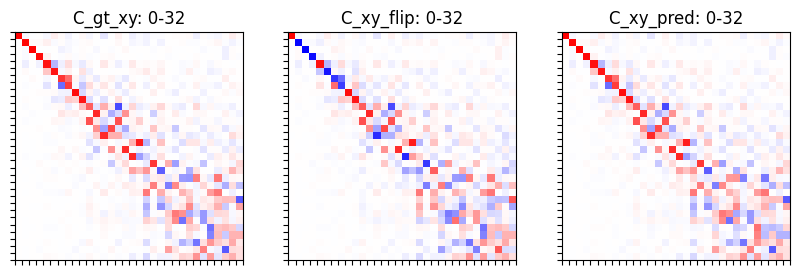

In [9]:
# evecs_orig, evecs_flip
# sign_flip_gt, sign_flip_predicted

# evecs_orig, evecs_flip * sign_flip_gt

C_gt_xy = test_shape['C_gt_xy'][0]
corr_second = test_shape['corr']
corr_first = train_dataset[0]['first']['corr']
evecs_first = train_dataset[0]['first']['evecs']


C_xy_flip = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second],
    evecs_first[corr_first]
    ).solution
C_xy_pred = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second] * torch.sign(sign_flip_predicted).cpu(),
    evecs_first[corr_first]
    ).solution


l = 0
h = 32


fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy, 'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_flip, 'C_xy_flip', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_xy_pred, 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)

plt.show()

[  4.3191085   5.604659    8.241713   12.354616   17.639172   35.425488
  35.707966   50.772854   54.049232   77.85384    90.059265  105.19333
 116.18642   119.89047   152.36339   163.68246   172.41501   192.6755
 208.39275   222.7534    241.50853   266.3765    276.21063   279.23553
 305.33328   323.9514    333.1928    338.99283   357.90332   362.21918
 364.9534   ]


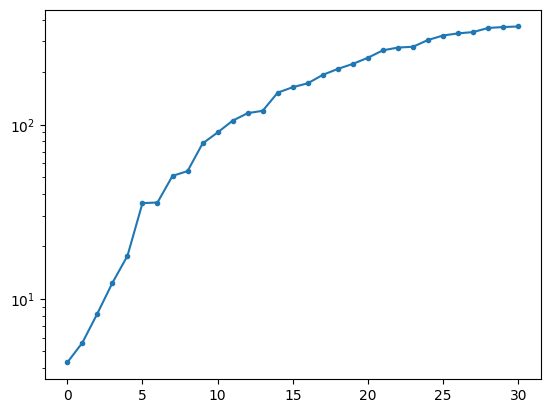

In [63]:
evals = train_dataset[0]['first']['evals'].cpu().numpy()[0, 1:32]
print(evals)

plt.plot(evals, '.-')
plt.yscale('log')
plt.show()